正在读取文件：Housing_rent_data.xlsx
正在读取文件：housing_analysis_results.xlsx
发现以下街区（工作表）：['Dachang', 'Yizhuang', 'Majuqiao']

分析街区：Dachang
数据形状：(1199, 2)
数据列：['租金', '面积']
使用列 '租金' 作为租金列，'面积' 作为面积列
异常值数量：59 (4.92%)
每平方米中位数租金：14.63元/月

分析街区：Yizhuang
数据形状：(1200, 2)
数据列：['月租金', '面积']
使用列 '月租金' 作为租金列，'面积' 作为面积列
异常值数量：115 (9.60%)
每平方米中位数租金：77.95元/月

分析街区：Majuqiao
数据形状：(1200, 2)
数据列：['租金', '面积']
使用列 '租金' 作为租金列，'面积' 作为面积列
异常值数量：24 (2.00%)
每平方米中位数租金：277.63元/月

各街区每平方米中位数租金：
         街区   每平方米中位数租金
0   Dachang   14.634146
1  Yizhuang   77.951389
2  Majuqiao  277.634365

各街区每平方米中位数房价：
         街区     每平方米中位数价格
0   DAchang   8695.652174
1  Yizhuang  58825.692121
2  Majuqiao  29246.473219

各街区房价租金比：
         街区   每平方米中位数租金     每平方米中位数价格      房价租金比
0   dachang   14.634146   8695.652174  49.516908
1  yizhuang   77.951389  58825.692121  62.887154
2  majuqiao  277.634365  29246.473219   8.778474

图表已保存为'各街区房价租金比.png'
分析结果已保存为'rent_analysis_results.xlsx'


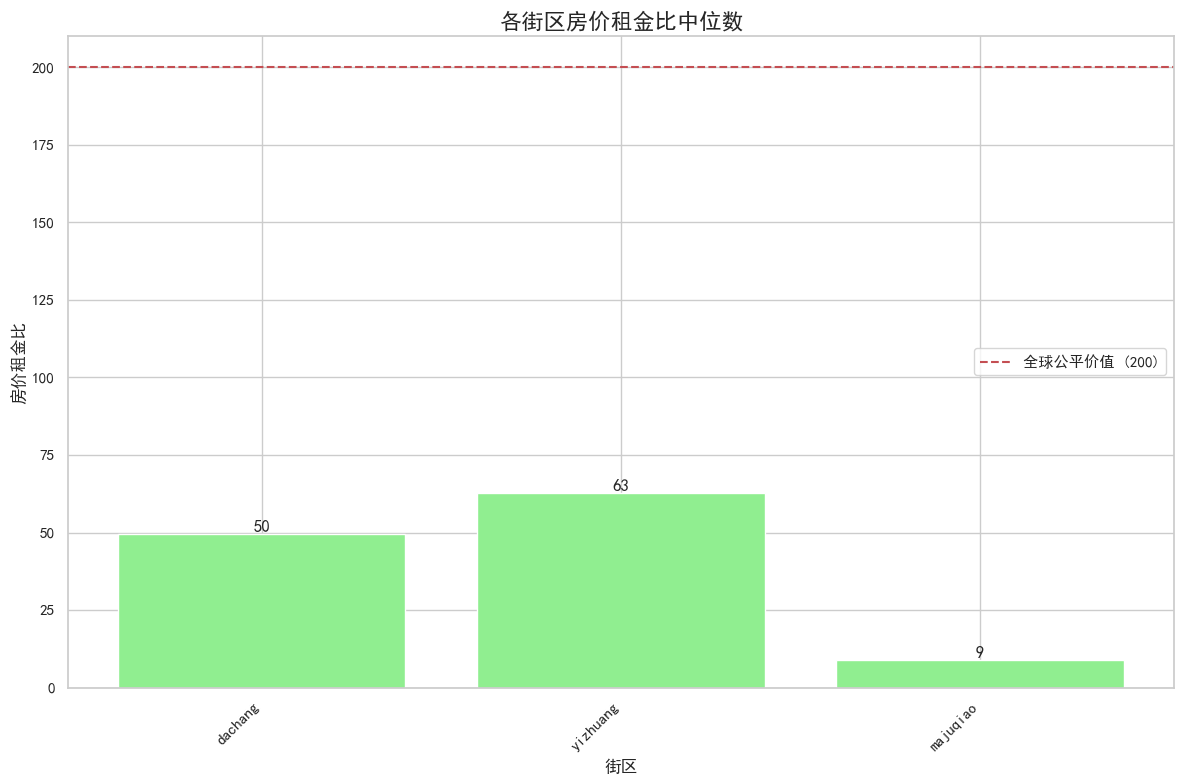

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置中文字体
sns.set(font='SimHei', style='whitegrid')
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 文件路径
rent_file_path = "Housing_rent_data.xlsx"
price_result_path = "housing_analysis_results.xlsx"

# 检查文件是否存在
if not os.path.exists(rent_file_path):
    print(f"错误：找不到租金数据文件 {rent_file_path}")
    exit()

if not os.path.exists(price_result_path):
    print(f"错误：找不到房价分析结果文件 {price_result_path}")
    exit()

print(f"正在读取文件：{rent_file_path}")
print(f"正在读取文件：{price_result_path}")

# 读取Excel文件中的所有工作表名称
excel_file = pd.ExcelFile(rent_file_path)
blocks = excel_file.sheet_names

print(f"发现以下街区（工作表）：{blocks}")

# 创建结果存储字典
results = {
    'block': [],
    'median_rent_per_m2': [],
    'data_description': [],
    'outliers_info': []
}

# 分析每个街区的租金数据
for block in blocks:
    print(f"\n分析街区：{block}")
    
    # 读取工作表数据
    df = pd.read_excel(rent_file_path, sheet_name=block)
    
    # 数据描述
    data_desc = df.describe()
    print(f"数据形状：{df.shape}")
    print(f"数据列：{df.columns.tolist()}")
    
    # 识别租金和面积列
    rent_columns = []
    for col in df.columns:
        if '租金' in str(col) or 'rent' in str(col).lower():
            rent_columns.append(col)
    
    area_columns = [col for col in df.columns if '面积' in str(col) or 'area' in str(col).lower()]
    
    if not rent_columns:
        print(f"警告：在工作表 {block} 中未找到租金相关列")
        continue
    
    if not area_columns:
        print(f"警告：在工作表 {block} 中未找到面积相关列")
        continue
    
    rent_col = rent_columns[0]
    area_col = area_columns[0]
    
    print(f"使用列 '{rent_col}' 作为租金列，'{area_col}' 作为面积列")
    
    # 处理带单位的租金数据（如"6200元/月"或纯数字）
    def convert_rent(value):
        try:
            if isinstance(value, str):
                # 移除可能的逗号、单位等
                value = value.replace(',', '').replace('元/月', '').replace('元', '').strip()
                return float(value)
            return float(value)
        except (ValueError, TypeError):
            return None
    
    # 处理带单位的面积数据（如"250㎡"）
    def convert_area(value):
        try:
            if isinstance(value, str):
                # 移除可能的逗号和面积单位
                value = value.replace(',', '').replace('㎡', '').strip()
                return float(value)
            return float(value)
        except (ValueError, TypeError):
            return None
    
    # 应用转换函数
    df[rent_col] = df[rent_col].apply(convert_rent)
    df[area_col] = df[area_col].apply(convert_area)
    
    # 删除包含NaN的行
    df = df.dropna(subset=[rent_col, area_col])
    
    # 确保面积大于0
    df = df[df[area_col] > 0]
    
    # 检查DataFrame是否为空
    if df.empty:
        print(f"警告：街区 {block} 在数据清洗后变为空数据框，跳过分析")
        continue
    
    # 计算每平方米租金
    df['rent_per_m2'] = df[rent_col] / df[area_col]
    
    # 检查异常值（使用IQR方法）
    Q1 = df['rent_per_m2'].quantile(0.25)
    Q3 = df['rent_per_m2'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['rent_per_m2'] < lower_bound) | (df['rent_per_m2'] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"异常值数量：{outlier_count} ({outlier_percentage:.2f}%)")
    
    # 计算中位数租金每平方米
    median_rent_per_m2 = df['rent_per_m2'].median()
    print(f"每平方米中位数租金：{median_rent_per_m2:.2f}元/月")
    
    # 存储结果
    results['block'].append(block)
    results['median_rent_per_m2'].append(median_rent_per_m2)
    results['data_description'].append(data_desc)
    results['outliers_info'].append({
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

# 创建租金结果DataFrame
rent_results_df = pd.DataFrame({
    '街区': results['block'],
    '每平方米中位数租金': results['median_rent_per_m2']
})

# 读取之前的房价分析结果
price_results_df = pd.read_excel(price_result_path)

print("\n各街区每平方米中位数租金：")
print(rent_results_df)

print("\n各街区每平方米中位数房价：")
print(price_results_df)

# 合并房价和租金数据
# 确保街区名称匹配（处理大小写差异）
rent_results_df['街区'] = rent_results_df['街区'].str.lower()
price_results_df['街区'] = price_results_df['街区'].str.lower()

merged_df = pd.merge(rent_results_df, price_results_df, on='街区', how='inner')

# 计算房价租金比（price-to-rent ratio）
# 注意：这里假设房价是总价，租金是月租金，所以计算年租金时需要乘以12
merged_df['房价租金比'] = merged_df['每平方米中位数价格'] / (merged_df['每平方米中位数租金'] * 12)

print("\n各街区房价租金比：")
print(merged_df)

# 可视化：各街区房价租金比条形图
plt.figure(figsize=(12, 8))
bars = plt.bar(merged_df['街区'], merged_df['房价租金比'], color='lightgreen')
plt.title('各街区房价租金比中位数', fontsize=16)
plt.xlabel('街区', fontsize=12)
plt.ylabel('房价租金比', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 添加全球公平价值参考线
plt.axhline(y=200, color='r', linestyle='--', label='全球公平价值 (200)')
plt.legend()

plt.tight_layout()

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}', 
             ha='center', va='bottom')

# 保存图表
plt.savefig('各街区房价租金比.png', dpi=300, bbox_inches='tight')
print("\n图表已保存为'各街区房价租金比.png'")

# 保存分析结果
merged_df.to_excel('rent_analysis_results.xlsx', index=False)
print("分析结果已保存为'rent_analysis_results.xlsx'")

# 显示图表
plt.show()